<a href="https://colab.research.google.com/github/jiku100/ShadowDetectionMethod/blob/main/DeepLearning/InstanceShadowDetection/maskrcnn_pytorch_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# True: 직접 훈련시킴, False: 이미 훈련된 모델을 가져옴
BOOL_TRAIN = True
# True: CUDA 사용, False: CPU 사용
BOOL_CUDA = True

필요한 라이브러리 설치

In [ ]:
%%shell

pip install cython
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-rd9lmvem
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-rd9lmvem
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263902 sha256=cba9976025b4469407fb94cf19848a518d4245a34ab194344d5c15990e0b981e
  Stored in directory: /tmp/pip-ephem-wheel-cache-asgcoxz7/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0
fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be376084 version check against PyTorch's CUDA version


In [ ]:
%%shell
wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1TP-tvpoPamX6wRBuBtfqExbbwR7yeGNs' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1TP-tvpoPamX6wRBuBtfqExbbwR7yeGNs" -O 'images.zip' && rm -rf /tmp/cookies.txt
unzip images.zip

--2021-06-10 05:14:14--  https://docs.google.com/uc?export=download&confirm=&id=1TP-tvpoPamX6wRBuBtfqExbbwR7yeGNs
Resolving docs.google.com (docs.google.com)... 142.250.107.101, 142.250.107.138, 142.250.107.100, ...
Connecting to docs.google.com (docs.google.com)|142.250.107.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-7o-docs.googleusercontent.com/docs/securesc/8ohrij258r8i5dbs3lfi13pc2v467q1i/3r5s8fugrdkvst24gi3klrhobrripkmu/1623302025000/07372639504144836018/16654223152731225245Z/1TP-tvpoPamX6wRBuBtfqExbbwR7yeGNs?e=download [following]
--2021-06-10 05:14:14--  https://doc-00-7o-docs.googleusercontent.com/docs/securesc/8ohrij258r8i5dbs3lfi13pc2v467q1i/3r5s8fugrdkvst24gi3klrhobrripkmu/1623302025000/07372639504144836018/16654223152731225245Z/1TP-tvpoPamX6wRBuBtfqExbbwR7yeGNs?e=download
Resolving doc-00-7o-docs.googleusercontent.com (doc-00-7o-docs.googleusercontent.com)... 172.253.117.132, 2607:f8b0:400e:c0a::84
Connectin

Dataset 클래스 정의

In [ ]:
import os
import numpy as np
import torch
import json
from PIL import Image


class SOBADataset(object):
    def __init__(self, root: str, transforms=None):

        self.imgs = list(sorted(os.listdir(os.path.join(root, "img"))))
        self.shadows = list(sorted(os.listdir(os.path.join(root, "shadow"))))

        self.root = root
        self.transforms = transforms

    def __getitem__(self, idx):
        # 이미지와 마스크를 읽어옵니다
        img_path = os.path.join(self.root, "img", self.imgs[idx])
        shadow_path = os.path.join(self.root, "shadow", self.shadows[idx])
        
        img = Image.open(img_path)
        mask = Image.open(shadow_path).convert("L")

        # numpy 배열을 PIL 이미지로 변환합니다
        mask = np.array(mask)
        # 인스턴스들은 다른 색들로 인코딩 되어 있습니다.
        shadow_ids = np.unique(mask)
        # 첫번째 id 는 배경이라 제거합니다
        shadow_ids = shadow_ids[1:]

        # 컬러 인코딩된 마스크를 바이너리 마스크 세트로 나눕니다
        masks = mask == shadow_ids[:, None, None]
        # 각 마스크의 바운딩 박스 좌표를 얻습니다
        num_objs = len(shadow_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # 모든 것을 torch.Tensor 타입으로 변환합니다
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # 객체 종류는 한 종류만 존재합니다(역자주: 예제에서는 사람만이 대상입니다)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # 모든 인스턴스는 군중(crowd) 상태가 아님을 가정합니다
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = dict()
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        
        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
dataset = SOBADataset('images')

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes`, `labels` and `masks`.

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
# use our dataset and defined transformations
dataset = SOBADataset('images', get_transform(train=True))
#dataset_test = SOBADataset('/content/drive/MyDrive/Colab Notebooks/SOBA/annotations/SOBA_train.json', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
#indices = torch.randperm(len(dataset)).tolist()
#dataset = torch.utils.data.Subset(dataset, indices[:-50])
#dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

#data_loader_test = torch.utils.data.DataLoader(
    #dataset_test, batch_size=1, shuffle=False, num_workers=4,
    #collate_fn=utils.collate_fn)

In [ ]:
if BOOL_CUDA:
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

model = get_instance_segmentation_model(num_classes)

if not BOOL_TRAIN:
  if BOOL_CUDA:
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1oA6z8A9KCzR_ASRIn97QJhW4qoTwvXES' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1oA6z8A9KCzR_ASRIn97QJhW4qoTwvXES" -O 'model_shadow_mrcnn.pt' && rm -rf /tmp/cookies.txt
    model.load_state_dict(torch.load('model_shadow_mrcnn.pt'))
    model.to(device)
  else:
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=15pjd7ND2ZjxdSr1qEvY_TJApPHnon3ny' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=15pjd7ND2ZjxdSr1qEvY_TJApPHnon3ny" -O 'model_shadow_mrcnn_cpu.pt' && rm -rf /tmp/cookies.txt
    model.load_state_dict(torch.load('model_shadow_mrcnn.pt', map_location=device))
  
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [ ]:
torch.cuda.empty_cache()

# let's train it for 10 epochs
num_epochs = 1

if BOOL_TRAIN:
  for epoch in range(num_epochs):
      # train for one epoch, printing every 10 iterations
      train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
      # update the learning rate
      lr_scheduler.step()
      # evaluate on the test dataset
      evaluate(model, data_loader, device=device)

Epoch: [0]  [ 0/92]  eta: 0:00:45  lr: 0.000060  loss: 4.0153 (4.0153)  loss_classifier: 0.4308 (0.4308)  loss_box_reg: 0.0522 (0.0522)  loss_mask: 2.7833 (2.7833)  loss_objectness: 0.6948 (0.6948)  loss_rpn_box_reg: 0.0542 (0.0542)  time: 0.4893  data: 0.1196  max mem: 12807
Epoch: [0]  [10/92]  eta: 0:00:25  lr: 0.000609  loss: 3.0746 (3.0883)  loss_classifier: 0.3333 (0.3146)  loss_box_reg: 0.0759 (0.1363)  loss_mask: 1.4455 (1.6097)  loss_objectness: 0.5580 (0.8265)  loss_rpn_box_reg: 0.1149 (0.2011)  time: 0.3170  data: 0.0150  max mem: 13189
Epoch: [0]  [20/92]  eta: 0:00:22  lr: 0.001158  loss: 2.2450 (2.4701)  loss_classifier: 0.2289 (0.2445)  loss_box_reg: 0.0759 (0.1486)  loss_mask: 1.3447 (1.3624)  loss_objectness: 0.1566 (0.5207)  loss_rpn_box_reg: 0.1149 (0.1939)  time: 0.3091  data: 0.0050  max mem: 13190
Epoch: [0]  [30/92]  eta: 0:00:19  lr: 0.001707  loss: 1.1898 (1.9948)  loss_classifier: 0.0943 (0.1955)  loss_box_reg: 0.0703 (0.1231)  loss_mask: 0.6057 (1.0794)  loss

In [ ]:
if BOOL_TRAIN:
  if BOOL_CUDA:
    torch.save(model.state_dict(), 'model_shadow_mrcnn.pt')

Now that training has finished, let's have a look at what it actually predicts in a test image

In [ ]:
# pick one image from the test set
img = dataset[2][0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

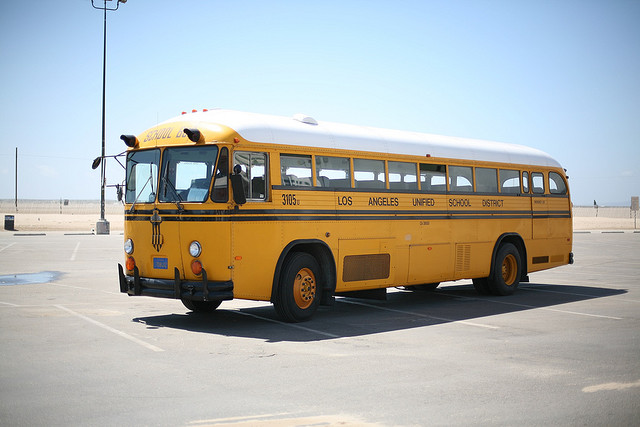

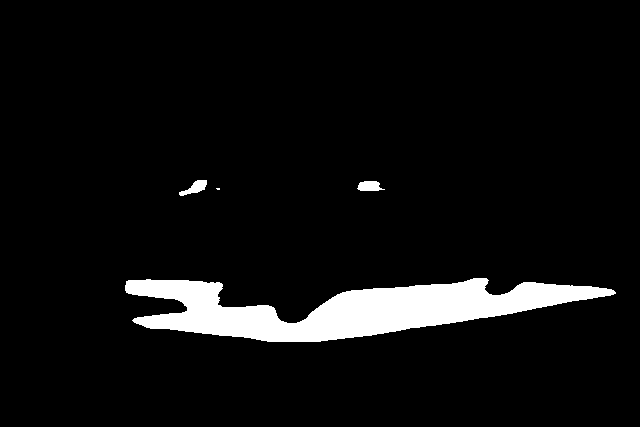

In [ ]:
masks = prediction[0]['masks']
res = torch.zeros((len(masks[0][0]), len(masks[0][0][0])), device=device)

for mask in prediction[0]['masks']:
  res += mask[0]/len(prediction[0]['masks'])

res = res.mul(255).byte().cpu().numpy()

for row in res:
  for x in list(range(len(row))):
    if row[x] > (255/(len(prediction[0]['masks'])/4)):
      row[x] = 255
    else:
      row[x] = 0

display(Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy()))
display(Image.fromarray(res))